# Tuning LoRA Hyperparameters - Experiments Vertical, Horizontal and r

## Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
%%capture
import sys
sys.path.append('src')

import boto3

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import HyperparameterTuner

import warnings
warnings.filterwarnings('ignore')

from src.util import (
    count_parameters, 
    calc_combinations
)
from src.nb_helper import (
    display_tuning_jobs,
    get_default_estimator_parameters,
    p,
    capture_results,
    graph_results,
    roberta_total, 
    roberta_learnable
)
from amtviz import visualize_tuning_job
import altair as alt
sm = boto3.client('sagemaker')

## Experiments

Let's try some experiments. For all of the experiments we use one learning rate (and weight decay / dropout) as a basis. We use the learning rate we found with the tuning job.

In [3]:
# We continue to use the results of the base lora tuner
%store -r
assert base_lora_tuner_name
base_lora_tuner = HyperparameterTuner.attach(base_lora_tuner_name)
base_lora_tuner_name

'lora-base-tuning-230810-1443'

In [4]:
base_lora_tuner.wait()
desc = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=base_lora_tuner.describe()['HyperParameterTuningJobName'])
print(desc['HyperParameterTuningJobName'], '=>', desc['HyperParameterTuningJobStatus'])
best_hyperparameters = desc['BestTrainingJob']['TunedHyperParameters']
print('Best parameters found:', best_hyperparameters)
best_hyperparameters = {k:float(v.replace('"', '')) for k, v in best_hyperparameters.items()}; best_hyperparameters

!
lora-base-tuning-230810-1443 => Completed
Best parameters found: {'sst2-learning-rate': '0.0003979340903356249'}


{'sst2-learning-rate': 0.0003979340903356249}

### Vertical / Layers

According to our intuition shouldn't we see that modules closer to the task head have bigger impact on the performance after finetuning?

With finetuning we are adapting the modules in our neural network. The task we want to finetune on is usually something different than we pre-trained on, e.g. we finetune on `sentiment analysis` of emails, while we pre-trained on `next token` prediction.

In this scenario we would expect that the impact of changes close to the bottom of the network, where the inputs come in, are smaller than the changes a the top of the network. As the understanding of language (bottom) would not be as strongly impacted as what to do with it (top).

So let's put this to the test and only tune some layers from the bottom, from the top, and evenly spread out.



In [5]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, TuningJobCompletionCriteriaConfig
vertical_estimator = PyTorch(**get_default_estimator_parameters())
vertical_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

n_trials = 5
hpt_ranges = {
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter(['12_upper', '12_lower', '12_even', 'all'])
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = vertical_estimator,
    base_tuning_job_name = 'lora-vertical',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}


lora_vertical_tuner = HyperparameterTuner(**tuner_parameters)
lora_vertical_tuner.fit(wait=False)

Using provided s3_resource


### Horizontal / Modules

We just submitted some tuning jobs to gauge the vertical (by layer) impact, but what about the horizontal approach to explore the impact of the individual modules, e.g. the query vectors?

There are a lot of interactions between these modules. Hence it would be good to also experiment with the impact of combining these modules. But given the combinatorial explosion of possible trials we stick to validating each module individually, for now. Another important (over-)simplification is to keep in mind is the `r` parameter. The number of parameters of a query vector is very different from the up-projection of the feed-forward layer. But to get a first impression we keep `r` fixed. These are the modules we look into:

Attention:
- q - query
- k - key
- v - value
- o - output

Feed Forward:
- u - up projection, i.e. 768 -> 3072
- d - down projection, i.e. 3072 -> 768


In [6]:
horizontal_estimator = PyTorch(**get_default_estimator_parameters())
horizontal_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

hpt_ranges = {
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter(['att_q', 'att_k', 'att_v', 'att_o', 'ff_u', 'ff_d'])
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = horizontal_estimator,
    base_tuning_job_name = 'lora-horizontal',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}

lora_horizontal_tuner = HyperparameterTuner(**tuner_parameters)
lora_horizontal_tuner.fit(wait=False)

Using provided s3_resource


### Rank

The third angle we explore is chosing `r`. When increasing `r` slowly, at some point we must cross the threshold where `r` becomes higher than the rank of `lora_A` and `lora_B`. Increasing `r` above that level will only make the training more costly with no additional benefit for our model's performance. What is that threshold?

_Sidebar: As we use the Random Search strategy with SageMaker AMT and accordingly no learning is happening in between the trials, theoretically, we could run all trials of this tuning in parallel. Also, we could run this tuning job in parallel to the two tuning jobs before (vertical and horizontal exploration), but we would need to increase our account limit for the training instance types to more than 20, which we haven't. 
So instead, we wait for the other tuning jobs to finish:_

In [7]:
lora_vertical_tuner.wait()

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [8]:
lora_r_estimator = PyTorch(**get_default_estimator_parameters())
lora_r_estimator.set_hyperparameters(**{'sst2-lora-r': 8, 'sst2-lora-config': 'all', **best_hyperparameters})

n_trials = 7
hpt_ranges = {
    'sst2-lora-r': CategoricalParameter([2, 4, 8, 16, 32]),
    'dummy': CategoricalParameter(list(range(0, n_trials))),
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = lora_r_estimator,
    base_tuning_job_name = 'lora-r',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}

lora_r_tuner = HyperparameterTuner(**tuner_parameters)
lora_r_tuner.fit(wait=False)

Using provided s3_resource


### Analysis

#### Vertical

'lora-vertical-230811-1906'

!
Tuning job lora-vertical-230811-1906 status: Completed

Number of training jobs with valid objective: 20
Lowest: 0.9266055226325989 Highest 0.9472476840019226


dummy sst2-lora-config                         TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds              TuningJobName  sst2_valid_acc
2       2              all  lora-vertical-230811-1906-018-23fa09f9         Completed 2023-08-11 19:24:41+02:00 2023-08-11 19:40:26+02:00                       945.0  lora-vertical-230811-1906        0.947248
0       4              all  lora-vertical-230811-1906-020-77608a37         Completed 2023-08-11 19:25:09+02:00 2023-08-11 19:43:50+02:00                      1121.0  lora-vertical-230811-1906        0.946101
4       0              all  lora-vertical-230811-1906-016-1f6c2248         Completed 2023-08-11 19:23:58+02:00 2023-08-11 19:42:23+02:00                      1105.0  lora-vertical-230811-1906        0.946101
14      0         12_lower  lora-vertical-230811-1906-006-b5f5f2aa         Completed 2023-08-11 19:07:46+02:00 2023-08-11 19:23:39+02:00                       953.0  lora-vertical-230811-1906        0.942661
1       3              all  lora-vertical-230811-1906-019-26cb9de0         Completed 2023-08-11 19:25:00+02:00 2023-08-11 19:40:45+02:00                       945.0  lora-vertical-230811-1906        0.942661
8       1          12_even  lora-vertical-230811-1906-012-0939ae23         Completed 2023-08-11 19:22:59+02:00 2023-08-11 19:37:43+02:00                       884.0  lora-vertical-230811-1906        0.942661
3       1              all  lora-vertical-230811-1906-017-f675610e         Completed 2023-08-11 19:24:36+02:00 2023-08-11 19:40:15+02:00                       939.0  lora-vertical-230811-1906        0.941514
12      2         12_lower  lora-vertical-230811-1906-008-41f14232         Completed 2023-08-11 19:08:02+02:00 2023-08-11 19:23:21+02:00                       919.0  lora-vertical-230811-1906        0.941514
9       0          12_even  lora-vertical-230811-1906-011-13eca009         Completed 2023-08-11 19:22:54+02:00 2023-08-11 19:38:24+02:00                       930.0  lora-vertical-230811-1906        0.939220
10      4         12_lower  lora-vertical-230811-1906-010-88e817f5         Completed 2023-08-11 19:07:59+02:00 2023-08-11 19:23:19+02:00                       920.0  lora-vertical-230811-1906        0.939220

Cache Hit/Miss: MMMMMMMMMMMMMMMMMMMM


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


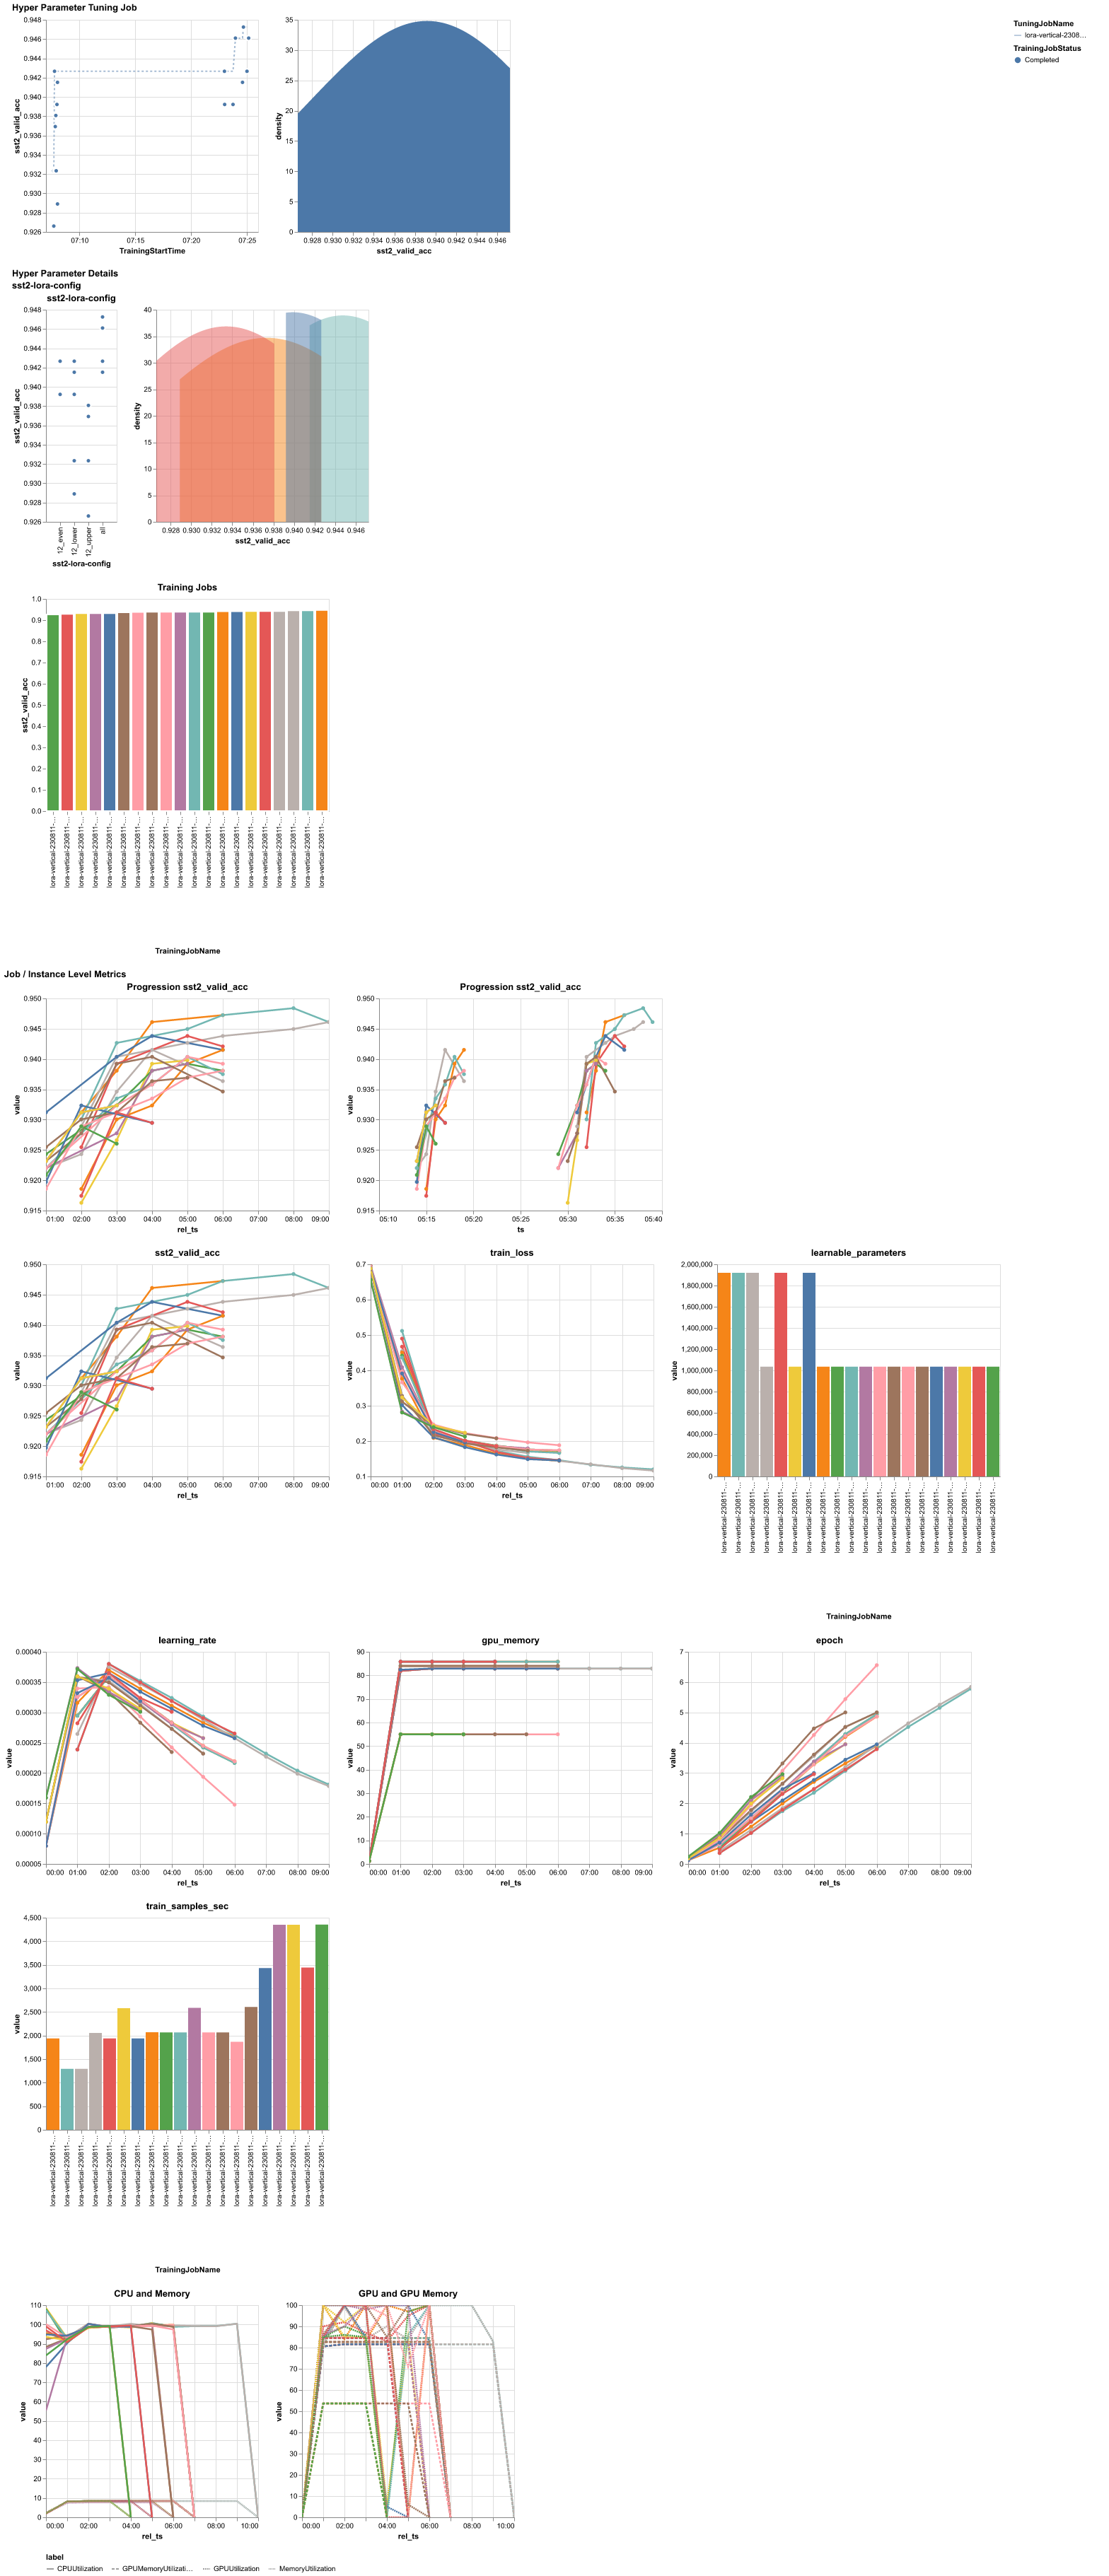

In [9]:
display_tuning_jobs(lora_vertical_tuner)

The vertical exploration was insightful, but not at all what I expected. 

We have a 12 layers model and compared these four configurations:

- __all__: We finetuned all 12 layers using LoRA. This is just for comparison and has double the amount of parameters than the other combinations.
- __lower__: We only finetuned adapters for the 6 lowest layers, closest to the inputs.
- __upper__: We only finetuned adapters for the 6 top layers, closest to the task.
- __even__: We only finetuned adapters for 6 layers, evenly spread out over. 

For our task `sentiment analysis` it appeared reasonable to me that a lot of the interpretation of the inputs could be close to the task head, and is not so much dependent on individual words being meaningful on their own. If that were the case then __upper__ should have outperformed __lower__. __Even__ was the best scenario. But even this scenario was not able to outperform __all__ with double the amount of parameters. 

If you feel inclined, and you ran this notebook for yourself, interact with it. You can select the scenario that is interesting to you and see how the results change. One notable find is that when selecting __upper__ the GPU memory utilization (`gpu_memory`) goes down from 80+% to 55%. Likely because the gradients then only have to be calculated for a relatively short path, just for the classifier and the upper layers. 

Also checkout how the training velocity (`train_samples_sec`).

'lora-horizontal-230811-1906'

.....................................................................................................................................................................!
Tuning job lora-horizontal-230811-1906 status: Completed

Number of training jobs with valid objective: 30
Lowest: 0.9059633016586304 Highest 0.9449541568756104


dummy sst2-lora-config                           TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds                TuningJobName  sst2_valid_acc
7       2             ff_u  lora-horizontal-230811-1906-023-391981df         Completed 2023-08-11 19:38:13+02:00 2023-08-11 19:53:17+02:00                       904.0  lora-horizontal-230811-1906        0.944954
5       4             ff_u  lora-horizontal-230811-1906-025-c3c6a76c         Completed 2023-08-11 19:40:26+02:00 2023-08-11 19:55:06+02:00                       880.0  lora-horizontal-230811-1906        0.943807
8       1             ff_u  lora-horizontal-230811-1906-022-11d62026         Completed 2023-08-11 19:37:00+02:00 2023-08-11 19:51:39+02:00                       879.0  lora-horizontal-230811-1906        0.943807
0       4             ff_d  lora-horizontal-230811-1906-030-76f0aaca         Completed 2023-08-11 19:43:19+02:00 2023-08-11 19:57:58+02:00                       879.0  lora-horizontal-230811-1906        0.939220
4       0             ff_d  lora-horizontal-230811-1906-026-dbbc46e0         Completed 2023-08-11 19:40:21+02:00 2023-08-11 19:55:05+02:00                       884.0  lora-horizontal-230811-1906        0.936927
2       2             ff_d  lora-horizontal-230811-1906-028-50027722         Completed 2023-08-11 19:40:53+02:00 2023-08-11 19:55:37+02:00                       884.0  lora-horizontal-230811-1906        0.935780
11      3            att_o  lora-horizontal-230811-1906-019-ae6394fa         Completed 2023-08-11 19:26:19+02:00 2023-08-11 19:41:03+02:00                       884.0  lora-horizontal-230811-1906        0.932339
1       3             ff_d  lora-horizontal-230811-1906-029-4b25548e         Completed 2023-08-11 19:42:25+02:00 2023-08-11 19:57:14+02:00                       889.0  lora-horizontal-230811-1906        0.932339
13      1            att_o  lora-horizontal-230811-1906-017-e87b2e6e         Completed 2023-08-11 19:24:16+02:00 2023-08-11 19:39:01+02:00                       885.0  lora-horizontal-230811-1906        0.932339
14      0            att_o  lora-horizontal-230811-1906-016-89bf2fb1         Completed 2023-08-11 19:24:12+02:00 2023-08-11 19:39:02+02:00                       890.0  lora-horizontal-230811-1906        0.930046

Cache Hit/Miss: MMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


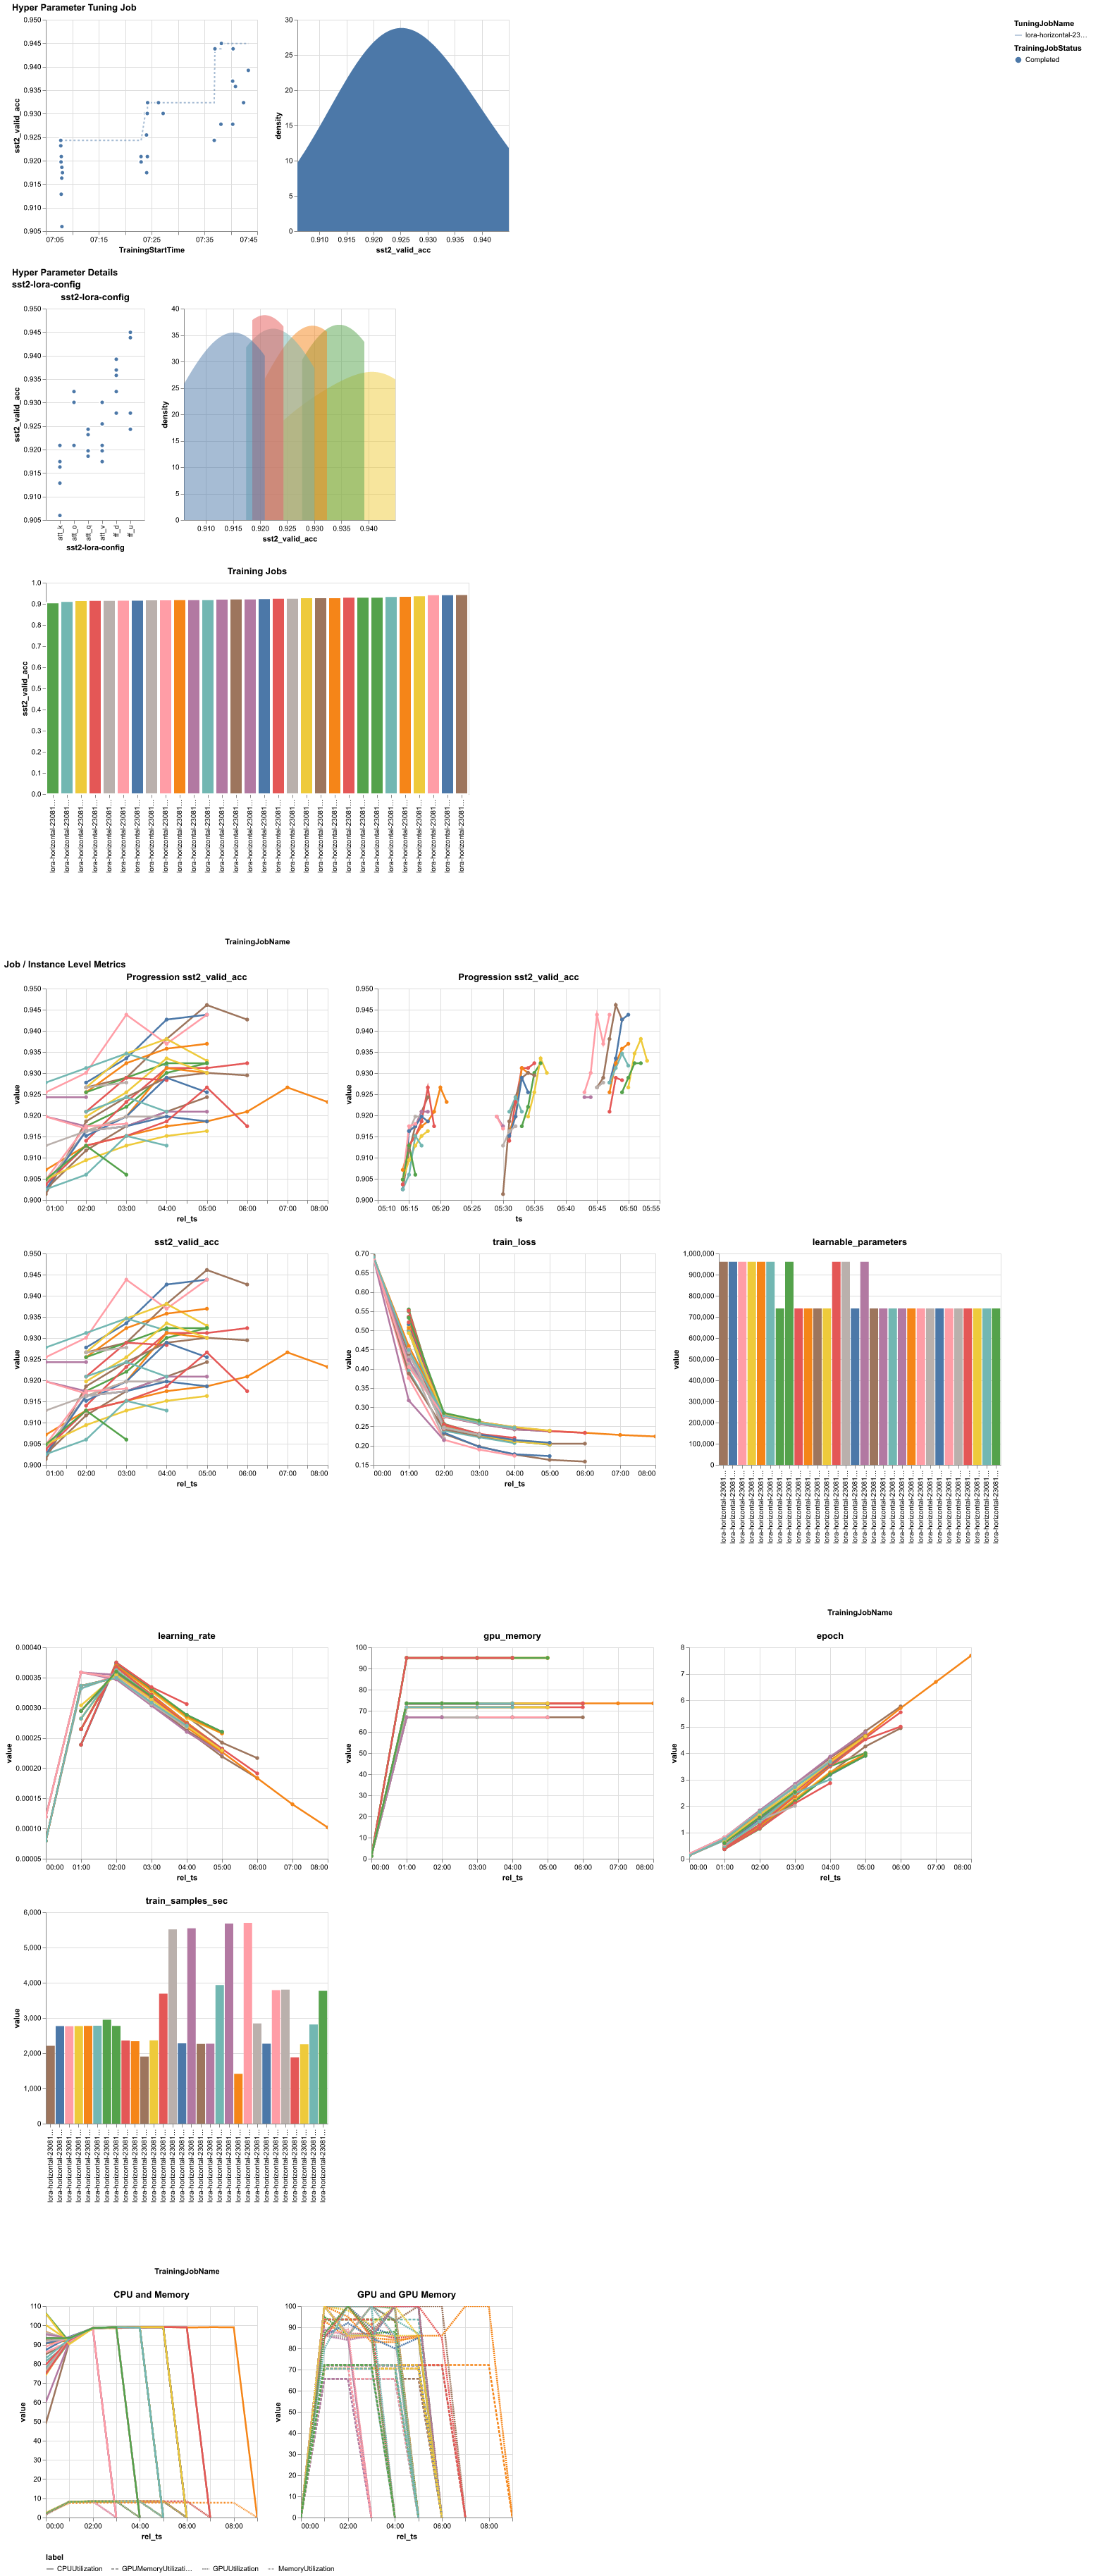

In [10]:
display_tuning_jobs(lora_horizontal_tuner)

#### Horizontal

The __horizontal__ was great. FIXME

Reviewing different values of `r` was different to what we hoped for. We saw with a larger `r` that we also got more variance. This was likely a sign of overfitting then. FIXME. This is also supported by the high variance on the `valid_loss` as you can see above. 

Also, we saw that bla bla, so let's try horizonatal combinations bla bla

'lora-r-230811-1945'

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
Tuning job lora-r-230811-1945        status: Completed

Number of training jobs with valid objective: 35
Lowest: 0.9346330165863037 Highest 0.9529816508293152


dummy  sst2-lora-r                  TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds       TuningJobName  sst2_valid_acc
18      3            4  lora-r-230811-1945-017-6deef99e         Completed 2023-08-11 20:04:26+02:00 2023-08-11 20:25:17+02:00                      1251.0  lora-r-230811-1945        0.952982
19      3            2  lora-r-230811-1945-016-114cf433         Completed 2023-08-11 20:03:28+02:00 2023-08-11 20:24:14+02:00                      1246.0  lora-r-230811-1945        0.951835
22      2            8  lora-r-230811-1945-013-1c0d1ec2         Completed 2023-08-11 20:02:36+02:00 2023-08-11 20:19:36+02:00                      1020.0  lora-r-230811-1945        0.950688
1       6           16  lora-r-230811-1945-034-ec6bde7f         Completed 2023-08-11 20:38:45+02:00 2023-08-11 20:59:31+02:00                      1246.0  lora-r-230811-1945        0.949541
2       6            8  lora-r-230811-1945-033-3728ca36         Completed 2023-08-11 20:38:01+02:00 2023-08-11 20:53:35+02:00                       934.0  lora-r-230811-1945        0.948394
32      0            8  lora-r-230811-1945-003-3b712aa9         Completed 2023-08-11 19:46:25+02:00 2023-08-11 20:02:04+02:00                       939.0  lora-r-230811-1945        0.948394
6       5           16  lora-r-230811-1945-029-172f04f5         Completed 2023-08-11 20:26:02+02:00 2023-08-11 20:41:37+02:00                       935.0  lora-r-230811-1945        0.948394
0       6           32  lora-r-230811-1945-035-be4d0ccd         Completed 2023-08-11 20:41:19+02:00 2023-08-11 20:58:34+02:00                      1035.0  lora-r-230811-1945        0.947248
13      4            4  lora-r-230811-1945-022-ac928e06         Completed 2023-08-11 20:19:41+02:00 2023-08-11 20:36:41+02:00                      1020.0  lora-r-230811-1945        0.947248
29      1            2  lora-r-230811-1945-006-7d51e16a         Completed 2023-08-11 19:46:33+02:00 2023-08-11 20:07:24+02:00                      1251.0  lora-r-230811-1945        0.947248

Cache Hit/Miss: MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


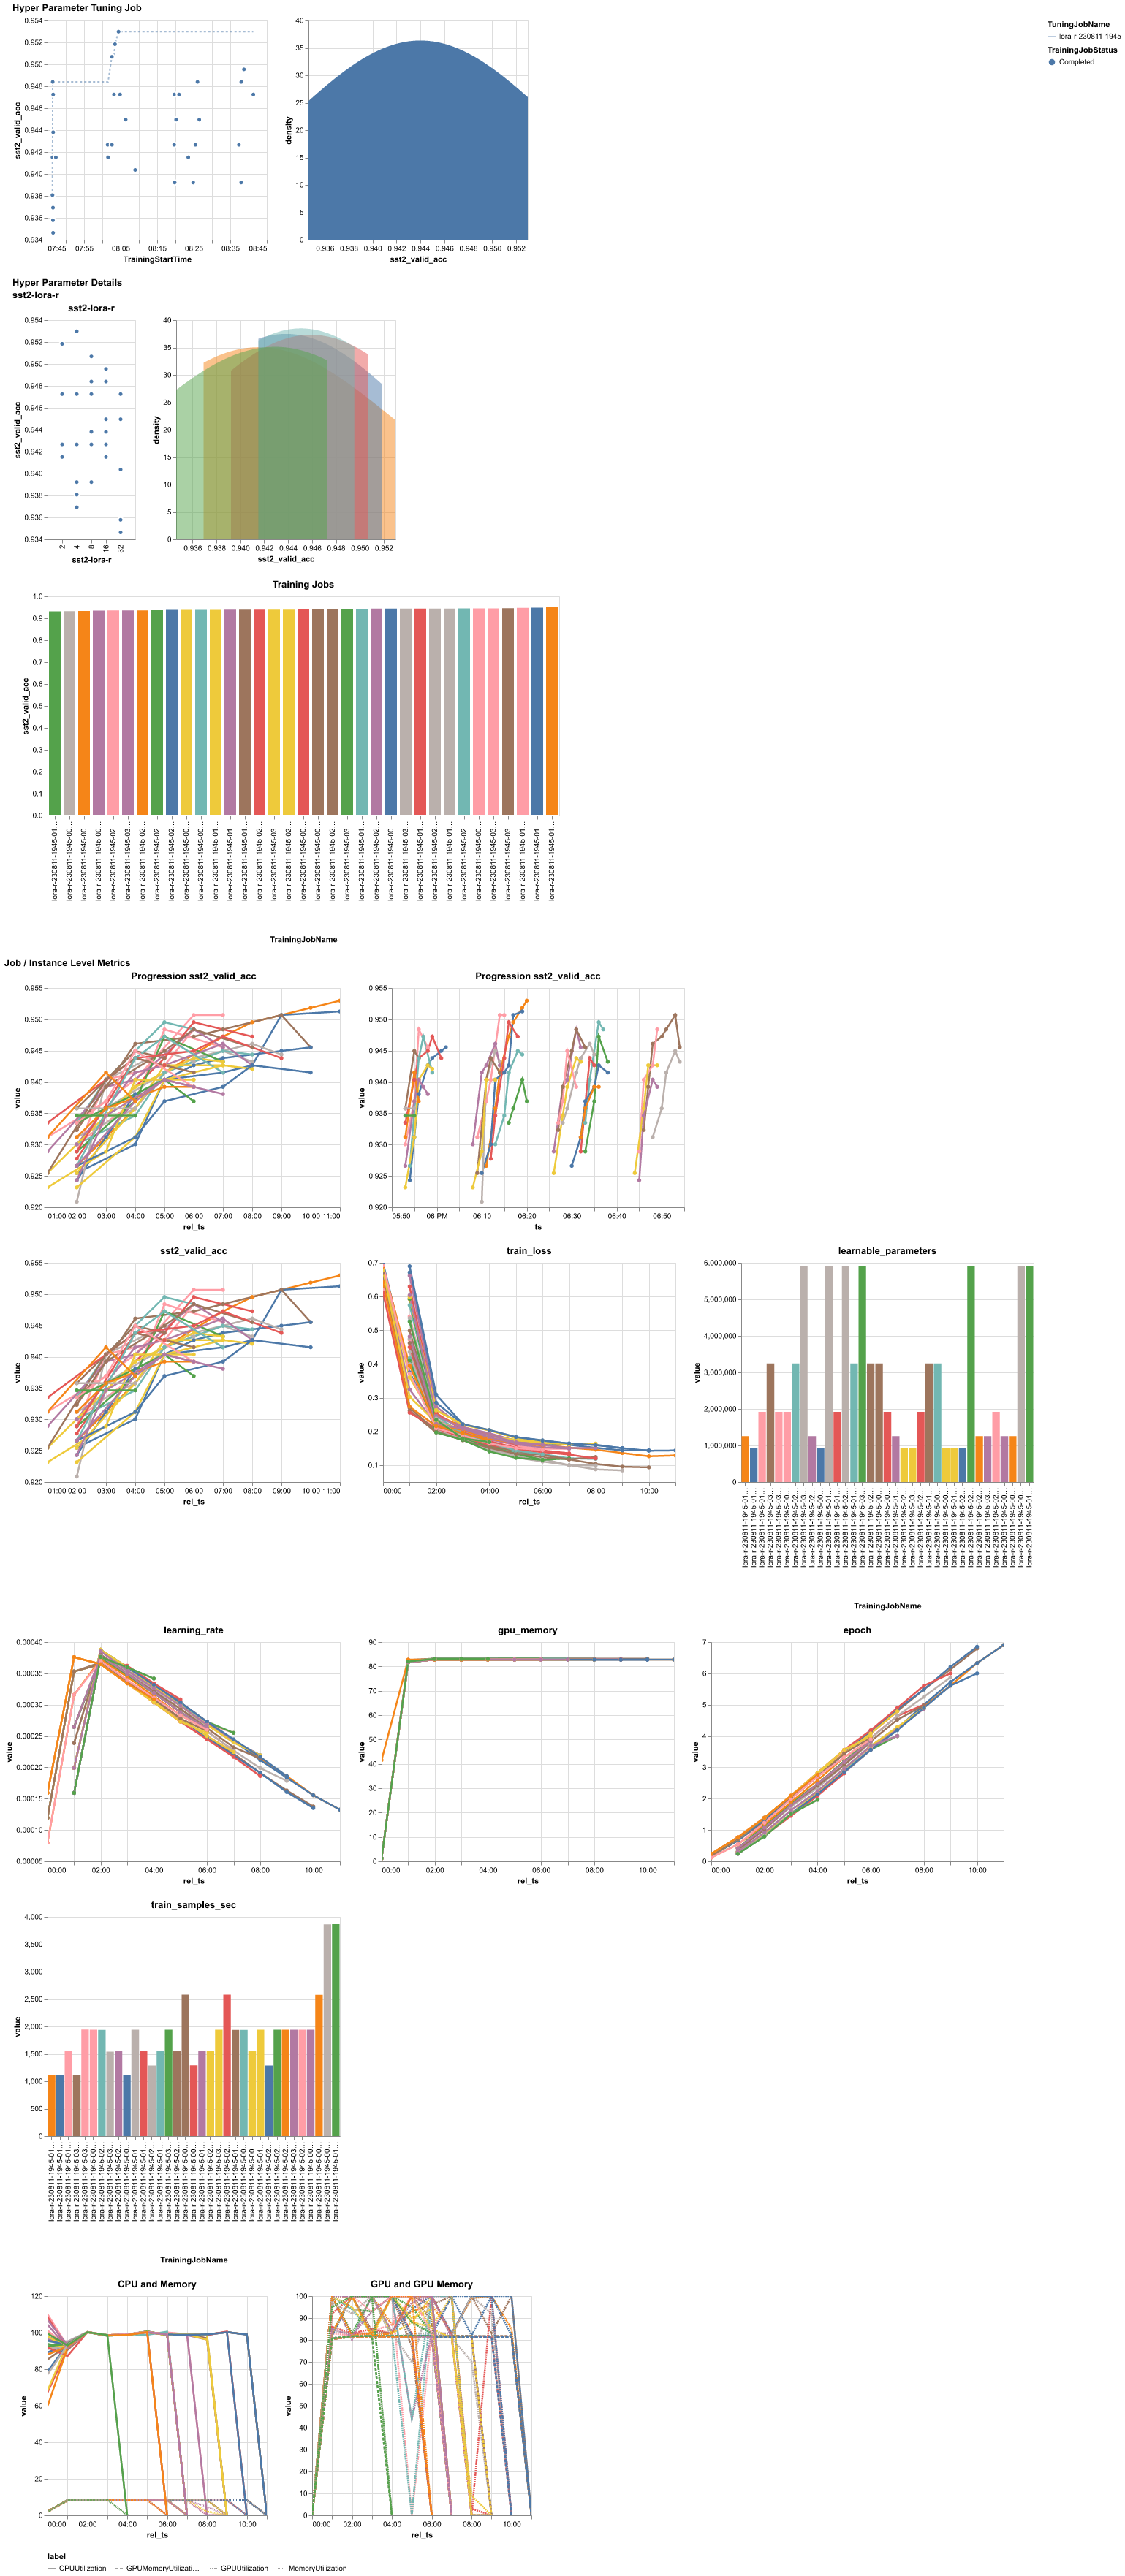

In [11]:
display_tuning_jobs(lora_r_tuner)

### Horizontal Combinations

In [12]:
horizontal_comb_estimator = PyTorch(**get_default_estimator_parameters())
horizontal_comb_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

n_trials = 4
hpt_ranges = {
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter(['att_q+ff_u','ff_d+ff_u','att_k+ff_u','att_v+ff_u','att_o+ff_u', 'att_qk+ff_u','att_qv+ff_u']) 
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = horizontal_comb_estimator,
    base_tuning_job_name = 'lora-horiz-comb',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}

lora_horiz_comb_tuner = HyperparameterTuner(**tuner_parameters)
lora_horiz_comb_tuner.fit(wait=False)

Using provided s3_resource


'lora-horiz-comb-230811-2101'

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
Tuning job lora-horiz-comb-230811-2101 status: Completed

Number of training jobs with valid objective: 28
Lowest: 0.9266055226325989 Highest 0.9518348574638367


dummy sst2-lora-config                           TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds                TuningJobName  sst2_valid_acc
14      1       att_v+ff_u  lora-horiz-comb-230811-2101-014-a9297d6c         Completed 2023-08-11 21:18:23+02:00 2023-08-11 21:33:48+02:00                       925.0  lora-horiz-comb-230811-2101        0.951835
15      0       att_v+ff_u  lora-horiz-comb-230811-2101-013-567ba296         Completed 2023-08-11 21:18:21+02:00 2023-08-11 21:33:45+02:00                       924.0  lora-horiz-comb-230811-2101        0.950688
27      0       att_q+ff_u  lora-horiz-comb-230811-2101-001-df04fcbd         Completed 2023-08-11 21:03:10+02:00 2023-08-11 21:18:35+02:00                       925.0  lora-horiz-comb-230811-2101        0.949541
26      1       att_q+ff_u  lora-horiz-comb-230811-2101-002-2aa17531         Completed 2023-08-11 21:03:12+02:00 2023-08-11 21:20:57+02:00                      1065.0  lora-horiz-comb-230811-2101        0.948394
19      0       att_k+ff_u  lora-horiz-comb-230811-2101-009-1cf5488f         Completed 2023-08-11 21:03:23+02:00 2023-08-11 21:18:48+02:00                       925.0  lora-horiz-comb-230811-2101        0.947248
18      1       att_k+ff_u  lora-horiz-comb-230811-2101-010-dd79849a         Completed 2023-08-11 21:03:27+02:00 2023-08-11 21:19:02+02:00                       935.0  lora-horiz-comb-230811-2101        0.947248
25      2       att_q+ff_u  lora-horiz-comb-230811-2101-003-95685828         Completed 2023-08-11 21:03:15+02:00 2023-08-11 21:21:05+02:00                      1070.0  lora-horiz-comb-230811-2101        0.946101
9       2       att_o+ff_u  lora-horiz-comb-230811-2101-019-652d4b57         Completed 2023-08-11 21:22:28+02:00 2023-08-11 21:39:42+02:00                      1034.0  lora-horiz-comb-230811-2101        0.946101
0       3      att_qv+ff_u  lora-horiz-comb-230811-2101-028-b71be893         Completed 2023-08-11 21:36:43+02:00 2023-08-11 21:52:27+02:00                       944.0  lora-horiz-comb-230811-2101        0.944954
1       2      att_qv+ff_u  lora-horiz-comb-230811-2101-027-353b8a8d         Completed 2023-08-11 21:36:47+02:00 2023-08-11 21:52:31+02:00                       944.0  lora-horiz-comb-230811-2101        0.944954

Cache Hit/Miss: MMMMMMMMMMMMMMMMMMMMMMMMMMMM


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


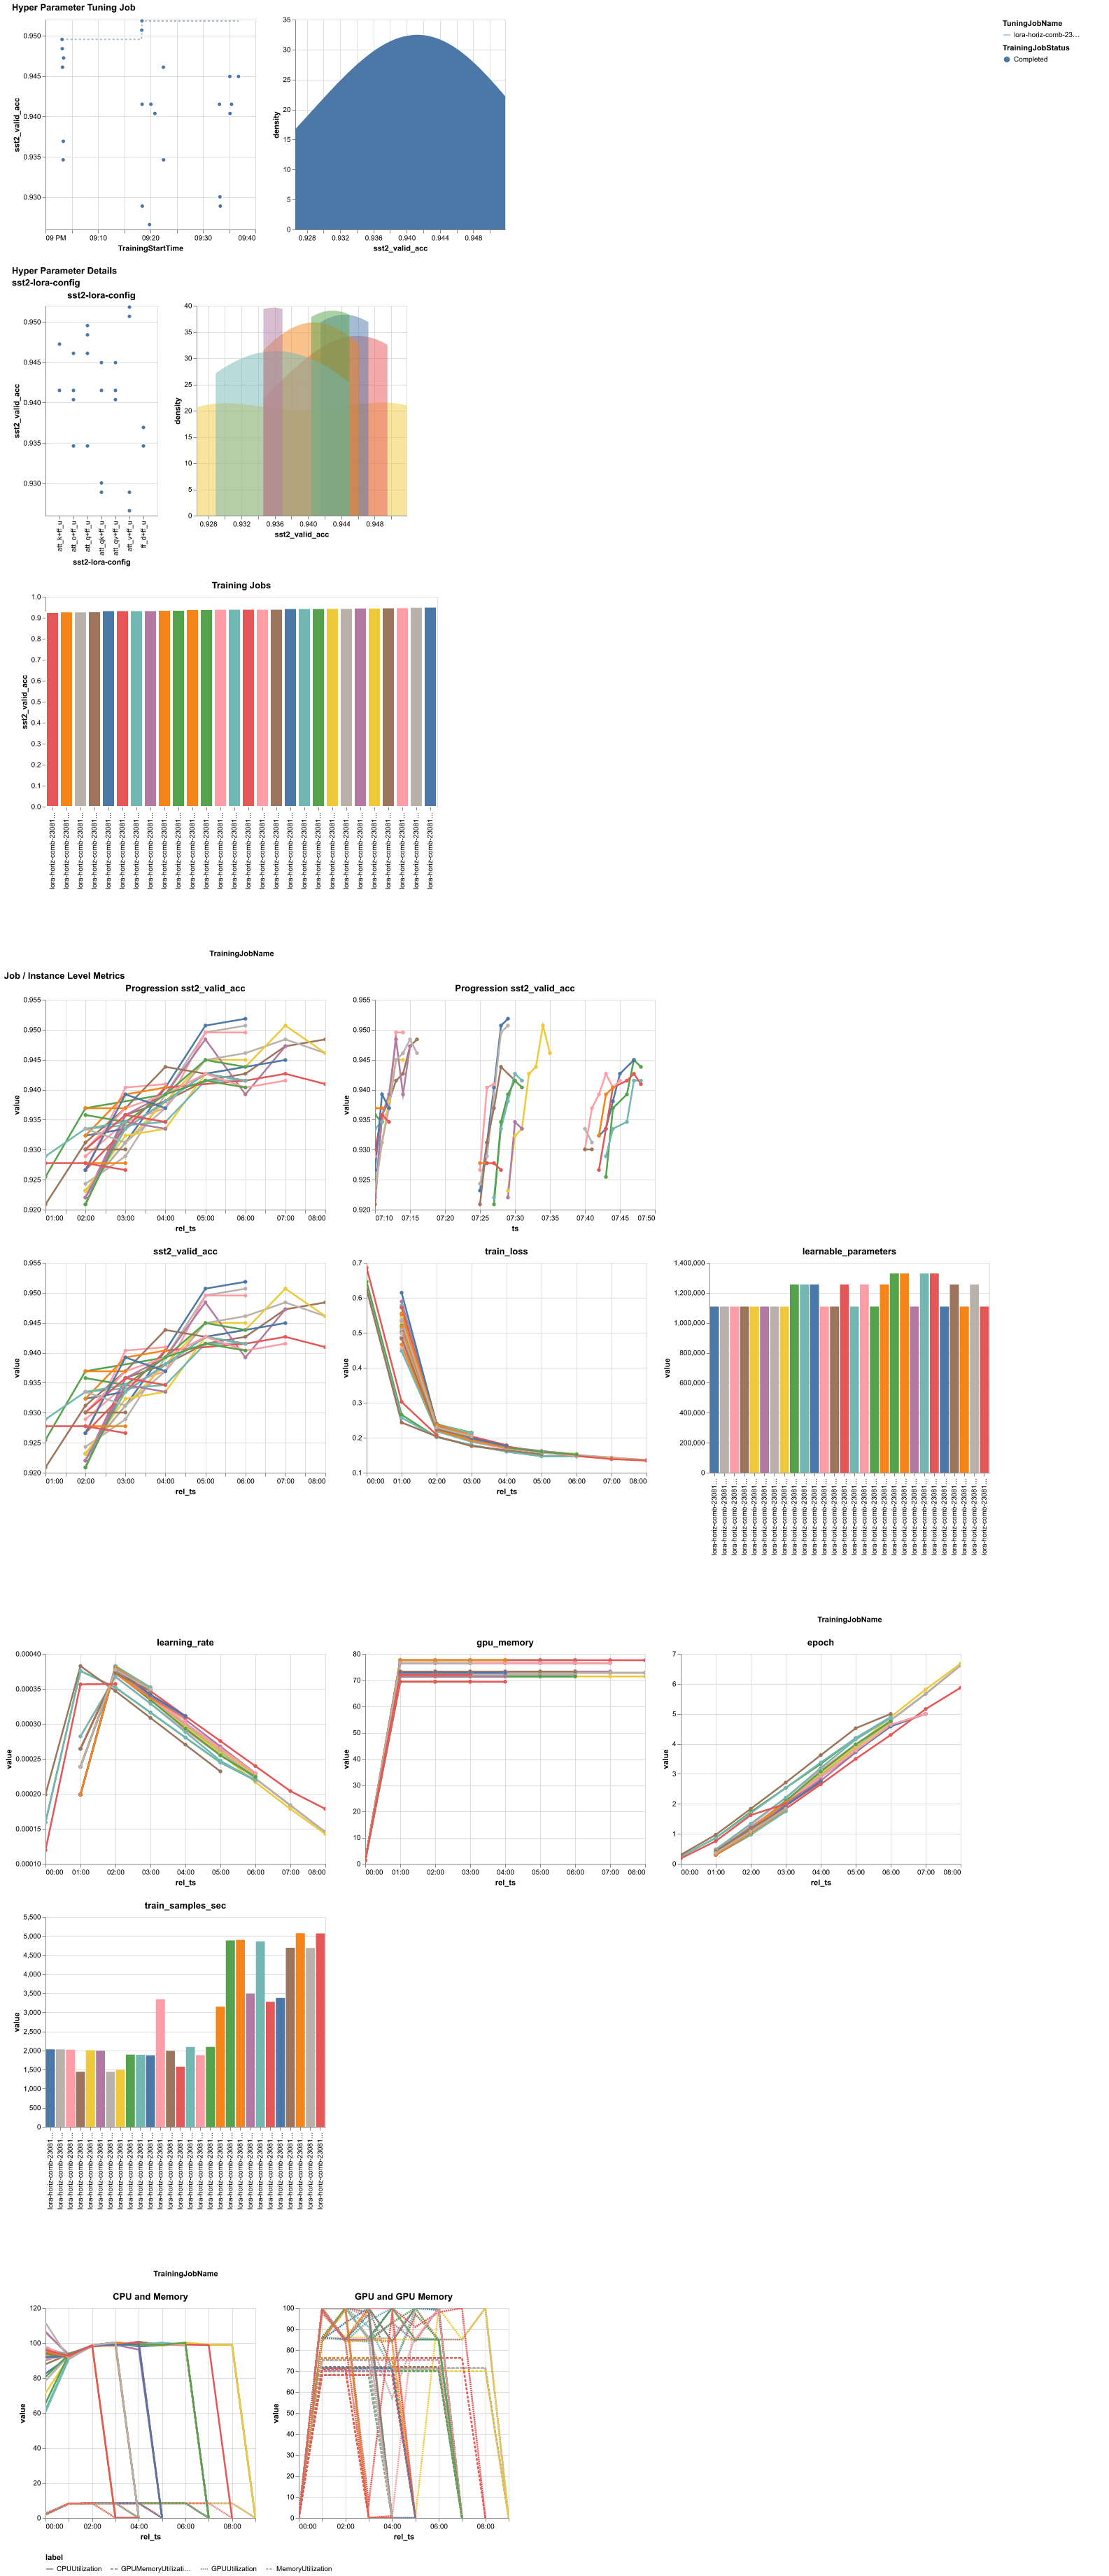

In [13]:
display_tuning_jobs(lora_horiz_comb_tuner)